In [ ]:
#imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.src.models import Sequential
from keras.src.layers import Dense, Dropout, Input
from keras.src.optimizers import Adam
from keras.src.callbacks import EarlyStopping
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate


In [ ]:
# reading and preprocessing data
df = pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv")
df['PM2.5'] = df['PM2.5'].fillna(df['PM2.5'].median())
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df = df.sort_values('datetime')
df = df.drop(columns=['No', 'cbwd', 'datetime', 'year'])



In [ ]:
# creationg new features
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['season'] = ((df['month'] % 12 + 3) // 3)

#  data preparation
features = [
    'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir',
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'season'
]
X = df[features]
y = np.log1p(df['PM2.5'])  # logarithm for stabilizing variance

# sacaling and spliting data
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, shuffle=True
)


In [ ]:
# Neural network architecture
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])
model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)

Epoch 1/50
877/877 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.6969 - mae: 1.4410 - val_loss: 0.5361 - val_mae: 0.5857
Epoch 2/50
877/877 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6929 - mae: 0.6589 - val_loss: 0.4766 - val_mae: 0.5558
Epoch 3/50
877/877 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5434 - mae: 0.5854 - val_loss: 0.4512 - val_mae: 0.5337
Epoch 4/50
877/877 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4944 - mae: 0.5563 - val_loss: 0.4437 - val_mae: 0.5244
Epoch 5/50
877/877 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4841 - mae: 0.5521 - val_loss: 0.4469 - val_mae: 0.5324
Epoch 6/50
877/877 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4749 - mae: 0.5428 - val_loss: 0.4324 - val_mae: 0.5214
Epoch 7/50
877/877 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4507 - mae: 0.5312 - val_loss: 0.4263 - val_mae: 0.5173
Epoch 8/50
877/877 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4425 - mae: 0.5233 - val_loss: 0.4207 - val_mae: 0.5114
Epoch 9/50
877/877 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lo

In [ ]:
# xgboost model
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=1.0,
    objective='reg:squarederror'
)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Predictions
pred_nn = model.predict(X_test).flatten()
pred_xgb = xgb_model.predict(X_test)
ensemble_pred = 0.5 * pred_nn + 0.5 * pred_xgb  # averaging

# reverse conversion
y_test_real = np.expm1(y_test)
nn_real = np.expm1(pred_nn)
xgb_real = np.expm1(pred_xgb)
ensemble_real = np.expm1(ensemble_pred)


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [ ]:
# metrics
def evaluate_model(name, y_true, y_pred):
    return {
        'Model': name,
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'R²': r2_score(y_true, y_pred)
    }

metrics = [
    evaluate_model("Neural Network", y_test_real, nn_real),
    evaluate_model("XGBoost", y_test_real, xgb_real),
    evaluate_model("Ensemble", y_test_real, ensemble_real)
]

print(tabulate(metrics, headers="keys", tablefmt="grid", floatfmt=".4f"))

+----------------+---------+-----------+--------+
| Model          |     MAE |       MSE |     R² |
+================+=========+===========+========+
| Neural Network | 41.7106 | 4124.0964 | 0.4826 |
+----------------+---------+-----------+--------+
| XGBoost        | 38.4409 | 3637.2885 | 0.5437 |
+----------------+---------+-----------+--------+
| Ensemble       | 39.4497 | 3789.6024 | 0.5245 |
+----------------+---------+-----------+--------+


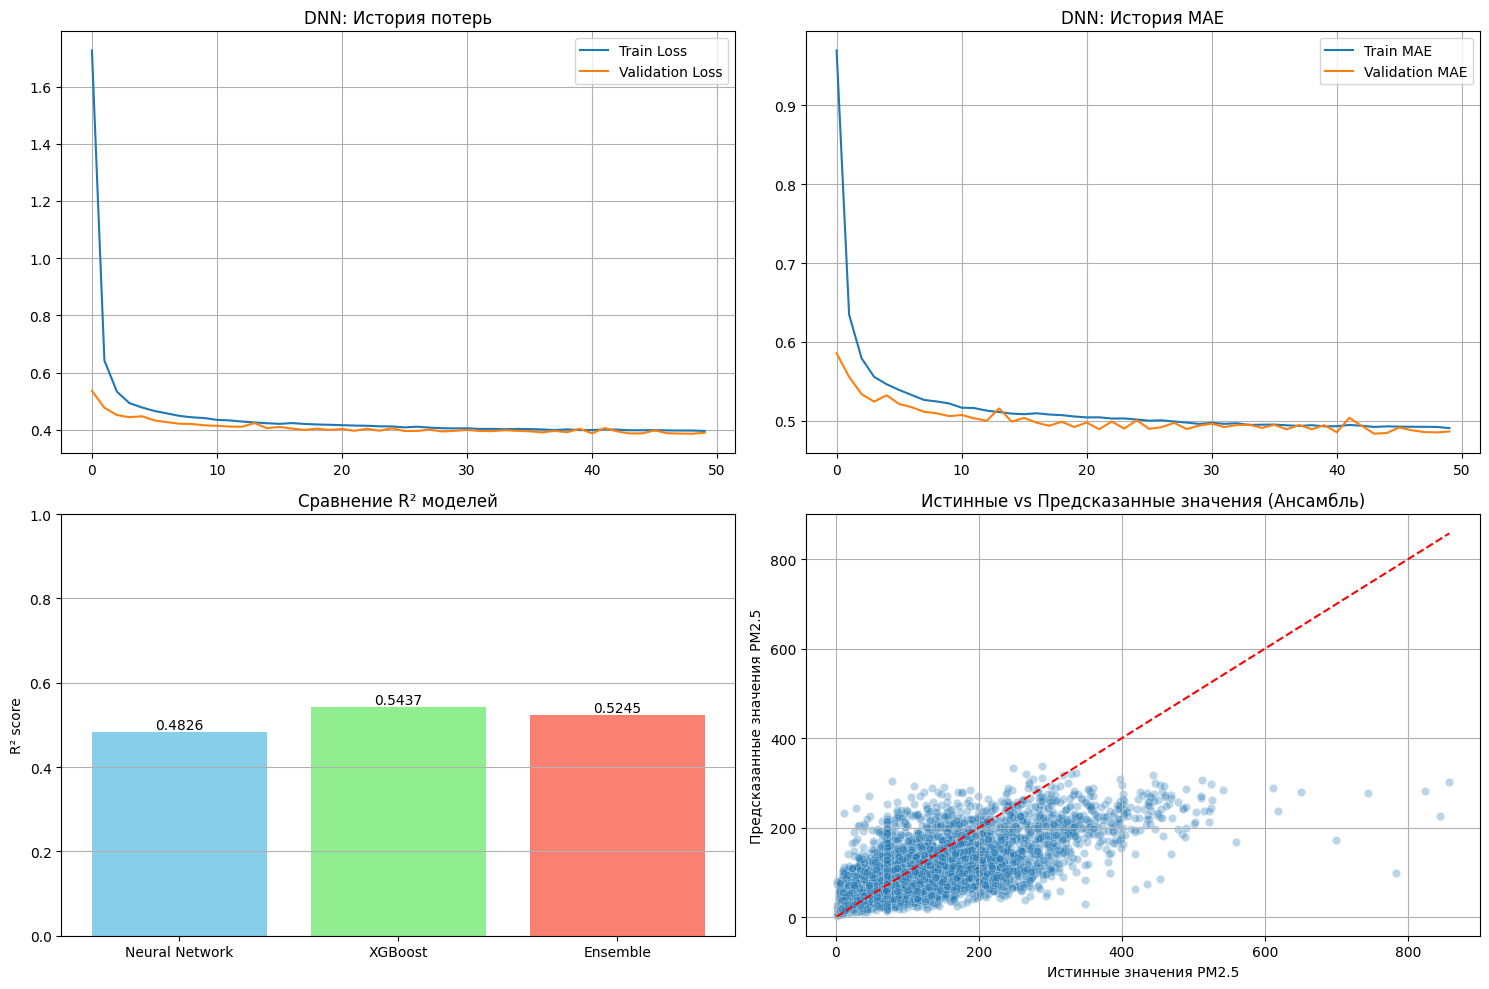

In [ ]:
# visualisation
plt.figure(figsize=(15, 10))

# NN fitting plot
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss history')
plt.legend()
plt.grid(True)

# MAE of NN
plt.subplot(2, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE history')
plt.legend()
plt.grid(True)

# R² comparisson
plt.subplot(2, 2, 3)
models = ['Neural Network', 'XGBoost', 'Ensemble']
r2_scores = [m['R²'] for m in metrics]
colors = ['skyblue', 'lightgreen', 'salmon']
bars = plt.bar(models, r2_scores, color=colors)
plt.title('R² comparisson')
plt.ylabel('R² score')
plt.ylim(0, 1)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')
plt.grid(True, axis='y')

# 4. Scatter plot for ensemble
plt.subplot(2, 2, 4)
sns.scatterplot(x=y_test_real, y=ensemble_real, alpha=0.3)
plt.plot([y_test_real.min(), y_test_real.max()],
         [y_test_real.min(), y_test_real.max()],
         'r--')
plt.title("true vs predicted values (ensemble)")
plt.xlabel("true PM2.5")
plt.ylabel("predicted PM2.5")
plt.grid(True)

plt.tight_layout()
plt.show()

# Сохранение результатов
results = pd.DataFrame({
    'True_PM2.5': y_test_real,
    'Predicted_PM2.5': ensemble_real
})

In [ ]:
results.to_csv("results.csv", index=False)
print("\nResults saved in results.csv")


Результаты сохранены в results.csv
